In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.8 MB/s 
     |████████████████████████████████| 9.9 MB 50.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv')

In [ ]:
df.head(10)

,Month,Accidental deaths
0,1973-01,9007
1,1973-02,8106
2,1973-03,8928
3,1973-04,9137
4,1973-05,10017
5,1973-06,10826
6,1973-07,11317
7,1973-08,10744
8,1973-09,9713
9,1973-10,9938


In [ ]:
df.reset_index()

,index,Month,Accidental deaths
0,0,1973-01,9007
1,1,1973-02,8106
2,2,1973-03,8928
3,3,1973-04,9137
4,4,1973-05,10017
...,...,...,...
67,67,1978-08,9827
68,68,1978-09,9110
69,69,1978-10,9070
70,70,1978-11,8633


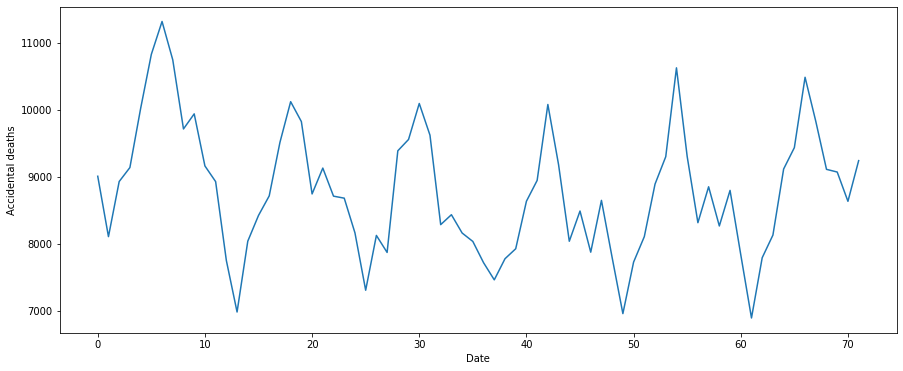

In [ ]:
df["Accidental deaths"].plot(figsize=(15, 6))
plt.xlabel("Date")
plt.ylabel("Accidental deaths")
plt.show()

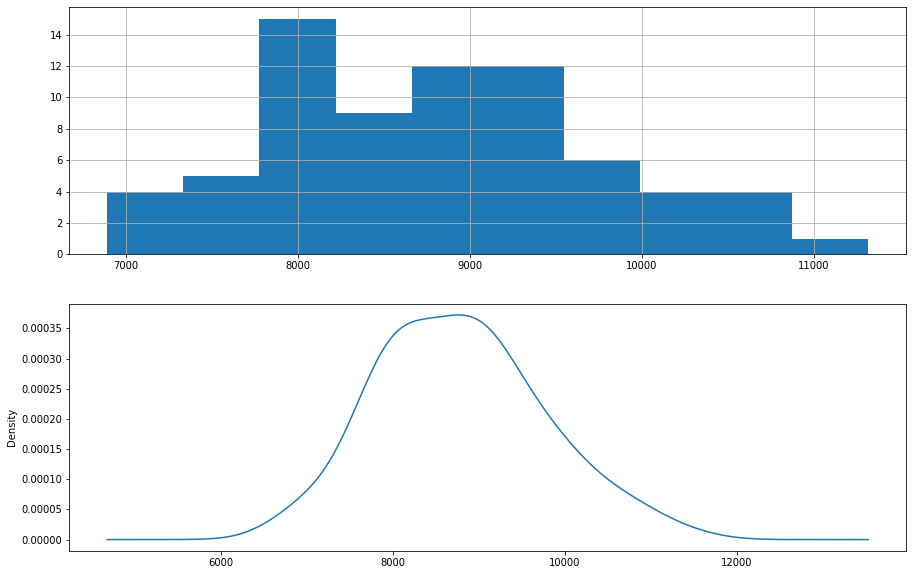

In [ ]:
plt.figure(1, figsize=(15,10))
plt.subplot(211)
df["Accidental deaths"].hist()
plt.subplot(212)
df["Accidental deaths"].plot(kind='kde')
plt.show()

Define the TS evaluation function.

In [ ]:
def evaluation(y_true, y_pred):
    met = {}
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    met['MSE'] = metrics.mean_squared_error(y_true, y_pred)
    met['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
    met['RMSE'] = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    met['MAPE'] = mean_absolute_percentage_error(y_true, y_pred)
    met['R2'] = metrics.r2_score(y_true, y_pred)

    data = pd.DataFrame(met, index=[0])
    print(data)

ADF test function to check for stationary data.

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='aic')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics','p-value','No of Lags','No of Obsv'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df['Accidental deaths'],'Accidental deaths')

Results of Dickey-Fuller Test for column: Accidental deaths
Test Statistics         -2.555798
p-value                  0.102481
No of Lags              12.000000
No of Obsv              59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


In [ ]:
X = df[['Accidental deaths']]
train, test = X[0:-30], X[-30:]

In [ ]:
stepwise_model = auto_arima(train, start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=False,
    d=2, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=661.243, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=647.934, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=645.593, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=659.289, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=649.509, Time=0.47 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=643.670, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.76 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=645.917, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=647.574, Time=0.23 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 4.129 seconds


In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -319.835
Date:                Wed, 21 Dec 2022   AIC                            643.670
Time:                        19:55:09   BIC                            647.048
Sample:                             0   HQIC                           644.892
                                 - 42                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6701      0.127     -5.289      0.000      -0.918      -0.422
sigma2      4.955e+05   1.07e+05      4.647      0.000    2.87e+05    7.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.91   Prob(JB):                         0.85
Heteroskedasticity (H):               0.51   Skew:                             0.21
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast, conf_int = stepwise_model.predict(n_periods=30, return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])

In [ ]:
df_conf = pd.DataFrame(conf_int, columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(42, 72)
df_conf = df_conf.set_index("new_index")

In [ ]:
evaluation(test, forecast)

            MSE         MAE         RMSE       MAPE         R2
0  2.410036e+07  4408.57947  4909.211676  51.651472 -28.844629


Rearrange the indexes for the plots to align.

In [ ]:
forecast["new_index"] = range(42, 72)
forecast = forecast.set_index("new_index")

In [ ]:
forecast[:5]

,close_pred
new_index,
42,9209.421996
43,9473.843992
44,9738.265988
45,10002.687984
46,10267.109979


Plot the results with confidence bounds.

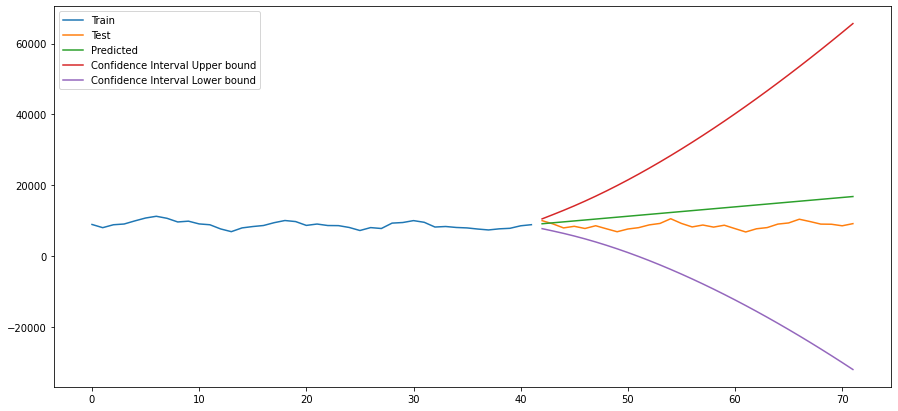

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,7]
plt.plot(train)
plt.plot(test)
plt.plot(forecast)
plt.plot(df_conf['Lower_bound'])
plt.plot(df_conf['Upper_bound'])
plt.legend(['Train', 'Test', 'Predicted', 'Confidence Interval Upper bound', 'Confidence Interval Lower bound'], loc='best')
plt.show()

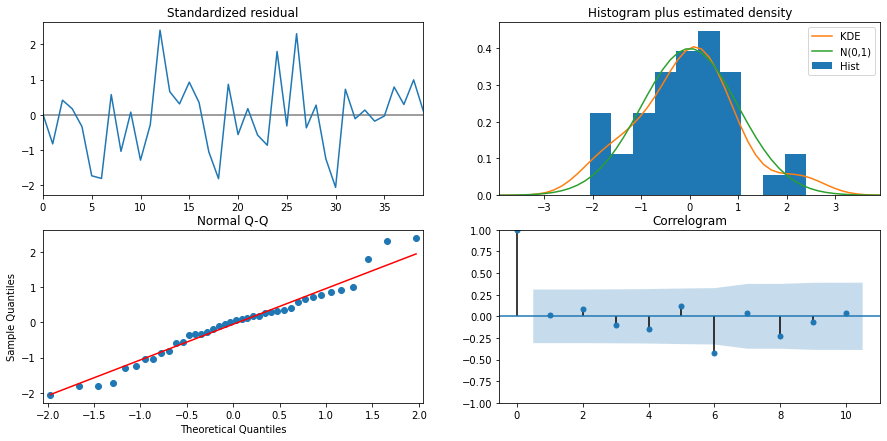

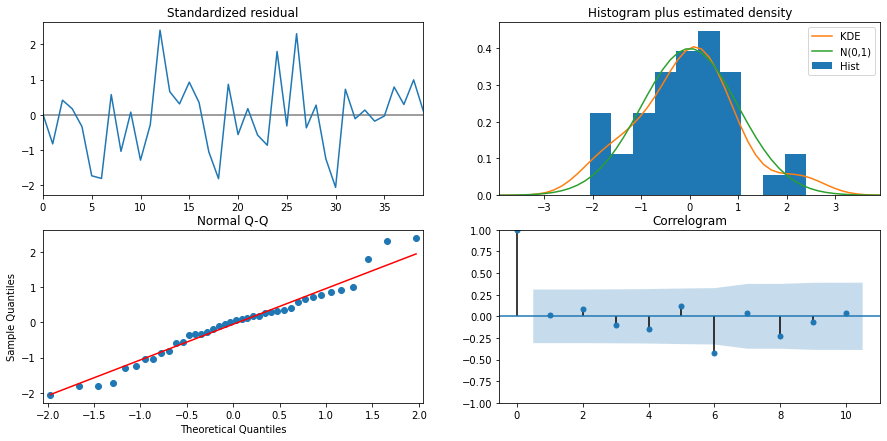

In [ ]:
stepwise_model.plot_diagnostics()